In [1]:
%pip install pandas
%pip install pymongo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pymongo import MongoClient
import pandas as pd

# Crea una SparkSession
spark = SparkSession.builder \
    .appName("MongoSparkConnector") \
    .getOrCreate()

# Conecta a MongoDB usando pymongo
client = MongoClient("mongodb://172.17.0.3:27017/")
db = client['docker']
collection = db['yt-data']

# Extrae los datos desde MongoDB
mongo_data = list(collection.find())

#print(mongo_data)

# Convierte los datos a un DataFrame de pandas
pdf = pd.DataFrame(mongo_data)




In [3]:
# Reemplazar la coma por un punto en la columna 'visualizaciones'
pdf['views'] = pdf['views'].str.replace(',', '.')

# Definir una función que limpie y transforme los valores de la columna
def transformar_visualizaciones(valor):
    # Obtener la parte numérica y el sufijo
    num, sufijo = valor.split(' ')[0], valor.split(' ')[1]
    
    # Transformar el valor basado en el sufijo
    if sufijo == 'M':
        return str(float(num) * 1e6).replace('.0', '')  # Multiplicar por 1 millón y convertir a string
    if sufijo == 'K':
        return str(float(num) * 1e3).replace('.0', '')  # Multiplicar por mil y convertir a string
    else:
        return num  # En caso de que haya otros sufijos en el futuro

# Aplicar la función a la columna
pdf['views'] = pdf['views'].apply(transformar_visualizaciones)



pdf['views'] = pdf['views'].astype(float)
# Mostrar el DataFrame resultante
print(pdf)

                          _id  \
0    6690e40eb9339c7f06db7dd5   
1    6690e40eb9339c7f06db7dd6   
2    6690e40eb9339c7f06db7dd7   
3    6690e40eb9339c7f06db7dd8   
4    6690e40eb9339c7f06db7dd9   
..                        ...   
344  669d8b50b9339c7f06db8003   
345  669d8b50b9339c7f06db8004   
346  669d8b50b9339c7f06db8005   
347  669d8b50b9339c7f06db8006   
348  669d8b50b9339c7f06db8007   

                                                titulo      views  \
0                                        Amaia - Nanai   393000.0   
1    Amaia - Santos Que Yo Te Pinte (Live | Vevo St...   158000.0   
2    Amaia - La Vida Imposible (Live | Vevo Studio ...   193000.0   
3    Amaia, Aitana - La Canción Que No Quiero Cantarte  2300000.0   
4                          Amaia - Bienvenidos Al Show  1700000.0   
..                                                 ...        ...   
344                ¿Qué hay en un SUPERMERCADO en USA?     9400.0   
345  Entrenamiento de CUÁDRICEPS en GOLDS GYM | Vlo

In [4]:
# Definir una función que limpie y transforme los valores de la columna
def transformar_anio(valor):
    # Obtener la parte numérica y el sufijo
    num, tiempo = valor.split(' ')[1], valor.split(' ')[2]
    
    # Transformar el valor basado en el sufijo
    if tiempo == 'años' or tiempo == 'año':
        return num 
    if tiempo == 'semanas' or tiempo == 'semana':
       return 0
    if tiempo == 'meses' or tiempo == 'mes':
        return 0
    else:
        return num 

# Aplicar la función a la columna

pdf['fecha_anio'] = pdf['fecha'].apply(transformar_anio)

# Mostrar el DataFrame resultante
print(pdf)

                          _id  \
0    6690e40eb9339c7f06db7dd5   
1    6690e40eb9339c7f06db7dd6   
2    6690e40eb9339c7f06db7dd7   
3    6690e40eb9339c7f06db7dd8   
4    6690e40eb9339c7f06db7dd9   
..                        ...   
344  669d8b50b9339c7f06db8003   
345  669d8b50b9339c7f06db8004   
346  669d8b50b9339c7f06db8005   
347  669d8b50b9339c7f06db8006   
348  669d8b50b9339c7f06db8007   

                                                titulo      views  \
0                                        Amaia - Nanai   393000.0   
1    Amaia - Santos Que Yo Te Pinte (Live | Vevo St...   158000.0   
2    Amaia - La Vida Imposible (Live | Vevo Studio ...   193000.0   
3    Amaia, Aitana - La Canción Que No Quiero Cantarte  2300000.0   
4                          Amaia - Bienvenidos Al Show  1700000.0   
..                                                 ...        ...   
344                ¿Qué hay en un SUPERMERCADO en USA?     9400.0   
345  Entrenamiento de CUÁDRICEPS en GOLDS GYM | Vlo

In [5]:
# Elimina la columna '_id' si es necesario, ya que no es serializable por defecto en Spark
if '_id' in pdf.columns:
    pdf = pdf.drop(columns=['_id'])

# Convierte el DataFrame de pandas a un DataFrame de Spark
df = spark.createDataFrame(pdf)

# Convertir el DataFrame a un RDD
rdd = df.select("user", "views").rdd


In [6]:
user_views_rdd = rdd.map(lambda row: (row['user'], row['views'])) \
                    .reduceByKey(lambda a, b: a + b)

# Convertir el RDD de nuevo a un DataFrame
user_views_df = user_views_rdd.toDF(["user", "total_views"])

# Mostrar los resultados
user_views_df.show()

+----------------+-----------+
|            user|total_views|
+----------------+-----------+
|    @amaiaromero|   2.5943E7|
|@ClaudiaNicolasa|  3.08559E7|
| @belen_aguilera|  3.49882E7|
+----------------+-----------+



In [7]:
# Convertir el DataFrame a un RDD
rdd = df.select("user", "views", "fecha_anio").rdd

# Usar map y reduceByKey para contar las visitas por usuario y año
user_year_views_rdd = rdd.map(lambda row: ((row['user'], row['fecha_anio']), row['views'])) \
                         .reduceByKey(lambda a, b: a + b)

# Convertir el RDD de nuevo a un DataFrame
user_year_views_df = user_year_views_rdd.map(lambda x: (x[0][0], x[0][1], x[1])) \
                                        .toDF(["user", "fecha_anio", "total_views"])

#user_year_views_df = user_year_views_df.sort_values(by='fecha_anio')
# Mostrar los resultados
user_year_views_df.show()

+----------------+----------+-----------+
|            user|fecha_anio|total_views|
+----------------+----------+-----------+
|    @amaiaromero|         4|  5500000.0|
|@ClaudiaNicolasa|         5|   288500.0|
|@ClaudiaNicolasa|         2|  7635000.0|
|    @amaiaromero|         0|   393000.0|
|    @amaiaromero|         3|   616000.0|
|@ClaudiaNicolasa|         3|  5241100.0|
|    @amaiaromero|         5|   1.0309E7|
|@ClaudiaNicolasa|         4|  2627800.0|
|    @amaiaromero|         2|  9125000.0|
|@ClaudiaNicolasa|         1|  8816700.0|
| @belen_aguilera|         4|  5493000.0|
| @belen_aguilera|         5|  5592000.0|
| @belen_aguilera|         0|  1224000.0|
| @belen_aguilera|         3|   1.0323E7|
| @belen_aguilera|         1|  2701000.0|
| @belen_aguilera|         2|  9655200.0|
|@ClaudiaNicolasa|         0|  6246800.0|
+----------------+----------+-----------+



In [8]:
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='fecha_anio', ylabel='total_views'>

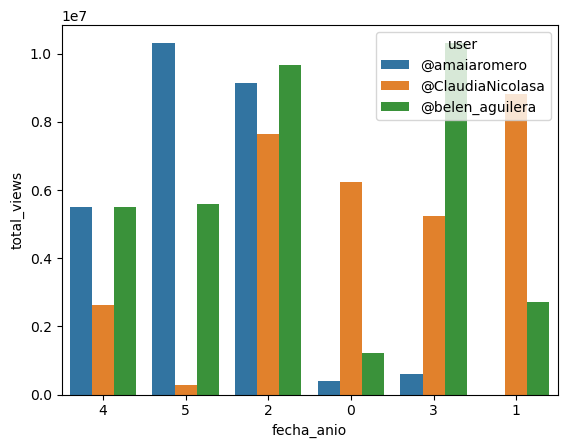

In [13]:
import seaborn as sns
import matplotlib as plt

df0 = user_year_views_df.toPandas()

#plt.figure(figsize=(10, 6))
sns.barplot(x='fecha_anio', y='total_views', hue='user', data=df0)
